In [126]:
import tensorflow as tf
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import copy

In [127]:
class NerualNet:
    def __init__(self, layers):
        self.layers = layers
        self.input = None
    def clear(self):
        self.input = None
        for k in self.layers:
            k.clear()
    def fowardPass(self,input):
        self.input = input
        output = input
        for k in self.layers:
            output = k.feedfoward(output)
        return output
    def backProp(self,gradient,lr=1):
        gradInput = gradient
        for k in self.layers[::-1]:
            gradInput = k.backprop(gradInput,lr)
        return gradInput
    
class Dense:
    def __init__(self,inputAmount,outputAmount,w=None,b=None):
        if not np.all(w):
            self.w = 10*np.random.random_sample(size=(outputAmount,inputAmount))
        else:
            self.w = w
        if not np.all(b):
            self.b = 10*np.random.random_sample(size=(outputAmount,1))      
        else:
            self.b = b
        self.input = None
    def clear(self):
        self.input = None
    def feedfoward(self,input):
        self.input = input
        return self.w @ self.input + self.b
    def ein(self,x,y):
        return np.einsum("i,j -> ij",x.T[0],y.T[0])
    def backprop(self,grad,lr=1):
        dz = grad
        self.w -= lr*self.ein(dz,self.input)
        self.b -= lr*dz
        return self.w.T @ dz
class act:
    def __init__(self):
        self.a_0 = None
        self.mask = None
        self.mask1 = None
    def feedfoward(self,a_0):
        self.a_0 = a_0
        self.mask = (a_0 >= 0)
        self.mask1 = (a_0 < 0)
        a = np.zeros_like(a_0)
        a[self.mask] = self.a_0[self.mask]+1
        a[self.mask1] = np.exp(self.a_0[self.mask1])
        return a
    def backprop(self,dz,lr=1):
        a = np.zeros_like(self.a_0)
        a[self.mask] = 1
        a[self.mask1] = np.exp(self.a_0[self.mask1])
        return dz * a
class softmax:
    def __init__(self):
        self.input = None
        pass
    def feedfoward(self,input):
        self.input = input
        return self.input/(np.sum(self.input)+1e-10)
    def backprop(self,grad,lr=1):
        summation = np.sum(self.input) + 1e-10
        return grad * (1/summation-self.input/(summation**2))
        


In [128]:
class ANN:
    def __init__(self,*layers):
        self.model = NerualNet(list(layers))
    def compute(self,inp):
        return self.model.fowardPass(inp)
    def gradDescent(self,inputs,outputs,lr,epochs,returnAcc = False):
        acc = []
        for i in range(epochs):
            for (input,output) in zip(inputs,outputs):
                dz = 2*(self.compute(input)-output)
                self.model.backProp(dz,lr)
            if(returnAcc):
                acc.append(self.testAcc2(inputs,outputs))
        return acc
    def testAccuracy(self,inputs,outputs):
        error = 0
        for(input, output) in zip(inputs,outputs):
            if(np.argmax(self.compute(input)) != output):
                error +=1
        return 1-error/len(inputs)
    def testAcc2(self,inputs,outputs):
        error = 0
        for(input, output) in zip(inputs,outputs):
            if(np.argmax(self.compute(input)) != np.argmax(output)):
                error +=1
        return 1-error/len(inputs)

In [129]:
x = [1,2]
for k in x[len(x)-2::-1]:
    print(k)

1


In [130]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1,1) / 255  # input for training
x_test = x_test.reshape(x_test.shape[0], -1,1) / 255  # input for testing
y_train = y_train.reshape(60_000,1)
def encode(input):
    z = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    z[0][input] = 1
    return np.transpose(z)
output_test = np.apply_along_axis(encode,1,y_train)

In [131]:
params = np.load("params.npz")

In [132]:
model = ANN(Dense(784,15,params["w0"],params["b0"]),act(),softmax(),Dense(15,10,params["w1"],params["b1"]),act(),softmax()) # saved model

In [133]:
model.testAcc2(x_train,output_test)

0.9473833333333334

In [134]:
model = ANN(Dense(784,15),act(),softmax(),Dense(15,10),act(),softmax())

In [139]:
y = model.gradDescent(x_train,output_test,4.0,5,True)

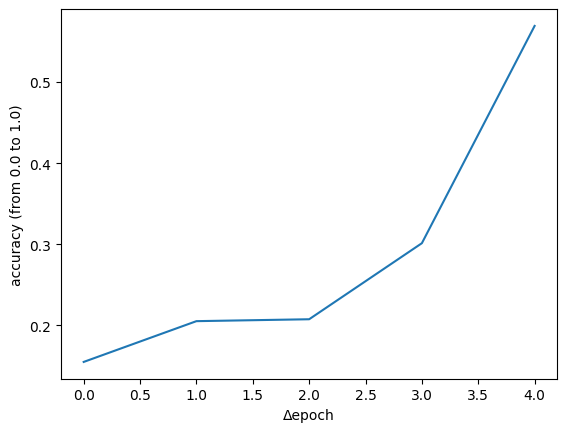

In [140]:
plt.plot(y)
plt.ylabel("accuracy (from 0.0 to 1.0)")
plt.xlabel("Δepoch")
plt.show()

In [141]:
y

[0.15498333333333336,
 0.20525000000000004,
 0.2076,
 0.30138333333333334,
 0.5692833333333334]